## Text Mining \& Topic Modeling

### Structure:
1. Preprocessing:
    * Document level preprocessing
    * Word level preprocesssing
2. Topic modelling
    * Word clouds
    * TF-IDF analysis
    * Latent Dirichlet Allocation (LDA): Finding meaning topics

### Goal:
Using abstracts from research articles on type 2 diabetes scraped from pubmed, we shall attempt divide these abstracts into meaningful topics (like e.g. lifestyle, treatment, etc.) using the concepts of topic modeling.



******************
$\textit{Authors:}$ Nikolaj Krebs \& Simon Guldager \
$\textit{Date:}$ 22-09-2024

In [3]:
import os
#import shutil

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#from sklearn.decomposition import LatentDirichletAllocation
#from sklearn.datasets import make_multilabel_classification
#from transformers import pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
#from sklearn.feature_extraction.text import CountVectorizer
#from sklearn.decomposition import LatentDirichletAllocation
#from sklearn.feature_extraction.text import  CountVectorizer

#!pip install  wordcloud
import textwrap
from wordcloud import WordCloud

import nltk
from nltk.stem import WordNetLemmatizer
#from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer

# Import the gensim library for topic modeling and other NLP tasks
import gensim
# Import the 'simple_preprocess' function from gensim for text preprocessing
#from gensim.utils import simple_preprocess
# Import 'corpora' from gensim for working with textual data
import gensim.corpora as corpora
# Import 'pprint' from the 'pprint' library to pretty-print output
from pprint import pprint


# Import pyLDAvis and pyLDAvis.gensim for LDA visualization
import pyLDAvis.gensim
# Import pickle for saving and loading Python objects
import pickle
# Import pyLDAvis for LDA visualization
import pyLDAvis
# Import os for file path operations

# downloaf nltk data
nltk.download('punkt');
nltk.download('wordnet');
nltk.download('stopwords');

# set print options
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

[nltk_data] Downloading package punkt to C:\Users\Simon
[nltk_data]     Andersen\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Simon
[nltk_data]     Andersen\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Simon
[nltk_data]     Andersen\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


...some useful functions

In [4]:

def print_row(data, idx, target_column, symbols_per_line=100):
    """
    Print a row of a DataFrame with word wrapping

    Parameters
    ----------
    data : DataFrame
        The DataFrame containing the data to be printed
    idx : int
        The index of the row to be printed
    target_column : str
        The name of the column to be printed
    symbols_per_line : int
        The number of symbols per line at which to wrap the text
    
    Returns
    -------
    None
        
    """
    value = str(data[target_column].iloc[idx])
    print(target_column)
    
    # Remove excess spaces
    value = ' '.join(value.split())
    
    # Wrap text while respecting word boundaries
    wrapped_value = textwrap.fill(value, width=symbols_per_line)
    
    print(wrapped_value)
    return

def print_list(list, elements_per_line=10):
    """
    Print a list with a specified number of elements per line
    """

    list_range = range(0, len(list), elements_per_line)

    for i in list_range:
        print(*list[i:i+elements_per_line])
    return

# Define a function to find unique words in a text
def find_unique_words(text, word_list):
    """
    Find unique words in a text. Append the unique words to a list.
    """
    for word in text.split():
        if word not in word_list:
            word_list.append(word)
    return

************************

## Preprocessing

#### Preprocessing is a huge chunk of the overall workload, as you may have noticed, and for text data, it involves some, but not usually all of the the following steps:

Document level preprocessing:
* Data cleaning (duplicate and noise removal)
* Data construction (deriving the features)
* Data reformatting and restructuring

Word level preprocessing:
* Word cleaning (Removal of illegal features and numbers, upper cases letters, mispellings etc)
* Removal of irrelevant words (stopwords)
* Tokenization
* n-gram construction
* Part-of-speech filtering
* Lemmatization
* Stemming
* Vectorization (embedding words as vectors in a large dimensional space)


*****************



#### Loading, looking at \& cleaning the data

... Load dataframes that have been created by scraping pubmed using the search words 'type 2 diabetes'. 

In [18]:
data400 = pd.read_csv('type+2+diabetes_400.csv', index_col=0)
data500 = pd.read_csv('type+2+diabetes_500.csv', index_col=0)

# concatenate the two dataframes and drop duplicates
data = (pd.concat([data400, data500], axis=0)).drop_duplicates('ArticleTitle')
data.count()

Authors         491
ArticleTitle    506
Date            493
Abstract        203
Keywords         74
Affiliations    331
dtype: int64

In [13]:
# let's have a look at the data
data.head()

,Authors,ArticleTitle,Date,Abstract,Keywords,Affiliations,Year,Month
0,"N. Javeed and AV. Matveyenko,","""Circadian Etiology of Type 2 Diabetes Mellitu...",Mar. 2018,"""The epidemic of Type 2 diabetes mellitus nece...",NaN,"""Department of Physiology and Biomedical Engin...",2018,3.0
1,"Y. Wu, Y. Ding, Y. Tanaka and W. Zhang,","""Risk factors contributing to type 2 diabetes ...",2014,"""Type 2 diabetes is a serious and common chron...","genetic factor, intervention trial., lifestyle...","""1. Lab of Molecular Immunology, Zhejiang Prov...",2014,NaN
2,"B. Fletcher, M. Gulanick and C. Lamendola,","""Risk factors for type 2 diabetes mellitus."",",Jan. 2002,"""Genetic, environmental, and metabolic risk fa...",NaN,"""University of North Florida, Department of Nu...",2002,1.0
3,"J. Damanik and E. Yunir,","""Type 2 Diabetes Mellitus and Cognitive Impair...",Apr. 2021,"""Type 2 diabetes mellitus (T2DM) is strongly a...","cognitive impairment, type 2 diabetes mellitus,","""Department of Internal Medicine, Faculty of M...",2021,4.0
4,"S. Brunton,","""Pathophysiology of Type 2 Diabetes: The Evolu...",Apr. 2016,"""This review article explores scientists' curr...",NaN,"""Primary Care Metabolic Group Charlotte, NC, U...",2016,4.0


... Article data without author or date is not worth much, so let's drop those. Also, we'll split the 'Date' column into a 'Month' and a 'Year' column

In [14]:
# drop rows with missing values in the 'Authors' and 'Date' column
data.dropna(subset=['Authors', 'Date'], inplace=True)

# Extract year and month from the 'Date' column
data['Year'] = (data['Date'].apply(lambda x: str(x)[-4:])).astype(int)

# Map month values Jan. Feb. etc. to numbers
months = {'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6, 'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12}

extract_months = lambda x: np.nan if not '.' in x else months[x.split('.')[0]]
data['Month'] = (data['Date'].astype(str).apply(extract_months)).astype(float)
data.head()

,Authors,ArticleTitle,Date,Abstract,Keywords,Affiliations,Year,Month
0,"N. Javeed and AV. Matveyenko,","""Circadian Etiology of Type 2 Diabetes Mellitu...",Mar. 2018,"""The epidemic of Type 2 diabetes mellitus nece...",NaN,"""Department of Physiology and Biomedical Engin...",2018,3.0
1,"Y. Wu, Y. Ding, Y. Tanaka and W. Zhang,","""Risk factors contributing to type 2 diabetes ...",2014,"""Type 2 diabetes is a serious and common chron...","genetic factor, intervention trial., lifestyle...","""1. Lab of Molecular Immunology, Zhejiang Prov...",2014,NaN
2,"B. Fletcher, M. Gulanick and C. Lamendola,","""Risk factors for type 2 diabetes mellitus."",",Jan. 2002,"""Genetic, environmental, and metabolic risk fa...",NaN,"""University of North Florida, Department of Nu...",2002,1.0
3,"J. Damanik and E. Yunir,","""Type 2 Diabetes Mellitus and Cognitive Impair...",Apr. 2021,"""Type 2 diabetes mellitus (T2DM) is strongly a...","cognitive impairment, type 2 diabetes mellitus,","""Department of Internal Medicine, Faculty of M...",2021,4.0
4,"S. Brunton,","""Pathophysiology of Type 2 Diabetes: The Evolu...",Apr. 2016,"""This review article explores scientists' curr...",NaN,"""Primary Care Metabolic Group Charlotte, NC, U...",2016,4.0


#### Word level data cleaning \& tokenization 
... since the abstracts contain the most information, we are going to focus on those in the remainder of this notebook. The code has been written, so that the target column for topic modeling could easily be changed to e.g. keywords or affiliations

In [20]:
# In the following, we will make topics based on the keywords column. You could instead choose to work with the abstract column.
column_to_tokenize = 'Abstract'
target_column = column_to_tokenize + '_tokenized'

# drop rows with missing values column to tokenize
data.dropna(subset=[column_to_tokenize], inplace=True)
# make a new columns for the tokenized target column
data[target_column] = data[column_to_tokenize].astype(str)


# get rid of quataion marks 
data[target_column] = data[target_column].map(lambda x: x.strip('"').strip())

In [21]:
# Decapitalize text
data[target_column] = data[target_column].apply(lambda x: x.lower())
# Remove numbers
data[target_column] = data[target_column].apply(lambda x: ''.join([i for i in x if not i.isdigit()]))
# Remove punctuation
tokenizer = RegexpTokenizer(r'\w+')
data[target_column] = data[target_column].apply(lambda x: tokenizer.tokenize(x))

... remove stopwords, i.e. uniformative words like 'I', 'you', 'me', but also words that are so common in the abstracts that they are not useful for dividing abstracts into topics, like e.g. 'diabetes'

In [22]:
# Remove common words such as me, our, you etc.
stop_words = nltk.corpus.stopwords.words('english')

# Add custom stop words 
new_stopwords = ['diabetes', 'type', 'mellitus']
stop_words.extend(new_stopwords)

print("List of words to be removed:\n")
print_list(stop_words, elements_per_line=10)

# remove stop words
data[target_column] = data[target_column].apply(lambda x: ' '.join([word for word in x if word not in (stop_words)]))

print("\nFirst row before preprocessing:")
print_row(data, target_column=column_to_tokenize, idx=0, symbols_per_line=100)   
print("\nFirst row after preprocessing:")
print_row(data, target_column=target_column, idx=0, symbols_per_line=100) 

List of words to be removed:

i me my myself we our ours ourselves you you're
you've you'll you'd your yours yourself yourselves he him his
himself she she's her hers herself it it's its itself
they them their theirs themselves what which who whom this
that that'll these those am is are was were be
been being have has had having do does did doing
a an the and but if or because as until
while of at by for with about against between into
through during before after above below to from up down
in out on off over under again further then once
here there when where why how all any both each
few more most other some such no nor not only
own same so than too very s t can will
just don don't should should've now d ll m o
re ve y ain aren aren't couldn couldn't didn didn't
doesn doesn't hadn hadn't hasn hasn't haven haven't isn isn't
ma mightn mightn't mustn mustn't needn needn't shan shan't shouldn
shouldn't wasn wasn't weren weren't won won't wouldn wouldn't diabetes
type mellitus

First row 

... Let's find the no. of words and no. of unique words in the target column

In [24]:
# Number of words in target column
Nwords = data[target_column].apply(lambda x: len(x.split()));
unique_words_before_lemmatization = []

for row in data[target_column]:
    find_unique_words(row, unique_words_before_lemmatization)

Nunique_words_before_lemmatization = len(unique_words_before_lemmatization);
# sort unique words
unique_words = sorted(unique_words_before_lemmatization);

print("Total Number of words in abstracts", Nwords.sum())
print("Number of unique words in abstracts: ", Nunique_words_before_lemmatization)
print("\nThe first 100 unique words: \n")
print_list(unique_words[:100], elements_per_line=10)

Total Number of words in abstracts 14973
Number of unique words in abstracts:  3405

The first 100 unique words: 

aberrations abilities ability abnomalies abnormal abnormalities absence absolute absorption abundance
abundant ac academic acanthosis acarbose accelerate accelerated acceptable acceptance accepted
access accompanied accompanies accompany accompanying accord according accordingly account accounting
accounts accumulating accumulation accurate ace achievable achieve achieved achievement achieving
acid acidosis acids acknowledge ackroyd across acs act acting action
actions activate activated activates activation active activities activity acupoint acupuncture
acute ad adapt adaptation adaptations adapted added addition additional additionally
additions address addressed addresses addressing adequate adhere adherence adhesion adipocytes
adipocytokines adipogenesis adipokines adiponectin adipose adiposity adjunct adjusted adjusting adjustment
administration admission adolescence

#### Lemmatization

We see that different forms of the same words are present like e.g. ability and abilities. This introduces unnecessary redundancy, and we fix it by lemmatization below, i.e. reducing different words forms to their unconjugated 'base', like e.g. letting balls --> ball and   tried --> try.

Another approach (which we won't use) is to reduce all words to their stem by using stemming (this approach will group different word classes together, letting e.g. analyze, analysis --> analy).

In [25]:
wordnet_lemmatizer = WordNetLemmatizer()

# Lemmatize target column. It can only lemmatize one word class at the time, so we need to specify the word classes
# (noun = n, verb = v, adjective = a, adverb = r, sattelite adjective = s) for each word in the text column
word_classes = ['n', 'v', 'a', 'r', 's']
for word_class in word_classes:
    data[target_column] = data[target_column].apply(lambda x: ' '.join([wordnet_lemmatizer.lemmatize(word, word_class) for word in x.split()]))

# Let's find the no. of unique words in target column after lemmatization
unique_words = []

for row in data[target_column]:
    find_unique_words(row, unique_words)
Nunique_words = len(unique_words);
# sort unique words
unique_words = sorted(unique_words);

print("Number of unique words in dataset after lemmatization: ", Nunique_words)
print("Through lemmatization, we have reduced the number of unique words by: ", Nunique_words_before_lemmatization - Nunique_words)
print("\nThe first 100 unique words after lemmatization: \n")
print_list(unique_words[:100], elements_per_line=10)


Number of unique words in dataset after lemmatization:  2710
Through lemmatization, we have reduced the number of unique words by:  695

The first 100 unique words after lemmatization: 

aberration ability abnomalies abnormal abnormality absence absolute absorption abundance abundant
ac academic acanthosis acarbose accelerate accept acceptable acceptance access accompany
accord accordingly account accumulate accumulation accurate ace achievable achieve achievement
acid acidosis acknowledge ackroyd across act action activate activation active
activity acupoint acupuncture acute ad adapt adaptation add addition additional
additionally address adequate adhere adherence adhesion adipocytes adipocytokines adipogenesis adipokines
adiponectin adipose adiposity adjunct adjust adjustment administration admission adolescence adolescent
adopt adoption adult adulthood advance advancement adverse adversely advise advocate
aerobic aetiology affair affect afflict affliction affordable africa african 

#### Representing the relative frequency of words with a wordcloud

c:\Users\Simon Andersen\miniconda3\envs\BigData\lib\site-packages\wordcloud\wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


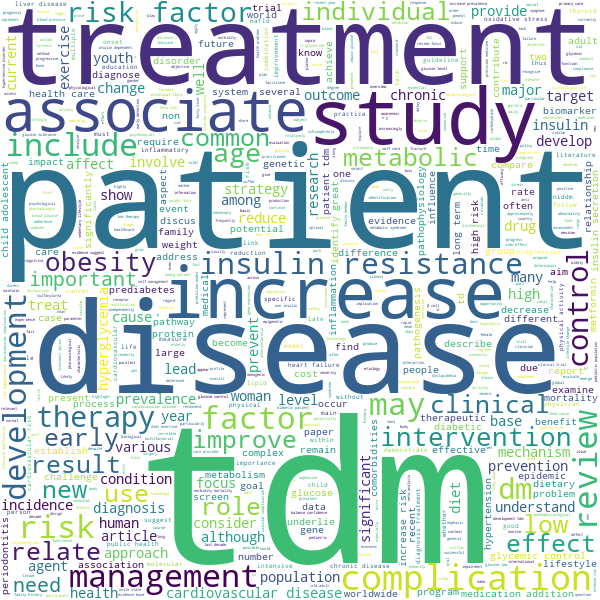

In [26]:
# Join the different processed titles together.
long_string = ','.join(list(data[target_column].values))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", height=600,width=600, max_words=5000, contour_width=6, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

#### At this point, we can go back and remove any additional words that we deem irrelevant.

************

## TF-IDF Analysis \& Vectorization
Let us construct a dataframe holding the tfidf score for all tokens. The tfidf score is a measure of the importance of each word in each document, in the sense that  
1) a word occurring more times in a given document is deemed more important 
2) a word occurring in many documents is deemed less important. This condition reduces the importance of very common words.

To do this, we use a vectorizer, which assigns a tuple (target column index, token_id) to each token (word in this case), as well as a tfidf score.

In [49]:
# Convert the target column to a list of strings
to=data[target_column].tolist()

## Store the indices in a list (for later use)
target_cols_idx = data.index.tolist()

# Initialize the vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Check if the list is empty
if len(to) == 0:
    print("The list is empty.")
else:
    # Create the tf-idf matrix
    tfidf_vector = tfidf_vectorizer.fit_transform(to)

# Let us print the first row of the tf-idf matrix (corresponding to the first row of the target column)
print("The TFIDF vector for the first row: \n", tfidf_vector[0])


The TFIDF vector for the first row: 
   (0, 463)	0.15965665725941047
  (0, 1509)	0.1081106167258455
  (0, 517)	0.21257178147834252
  (0, 1948)	0.11491412893157851
  (0, 2438)	0.12308672482267857
  (0, 2061)	0.22908491743413148
  (0, 1735)	0.20085552506208854
  (0, 2168)	0.08730652580343189
  (0, 102)	0.1314272648873675
  (0, 2524)	0.15372614622381264
  (0, 1788)	0.14983499381178125
  (0, 205)	0.15611299673425655
  (0, 2613)	0.12961690442939483
  (0, 2425)	0.27061781162368587
  (0, 400)	0.42514356295668504
  (0, 1406)	0.15965665725941047
  (0, 870)	0.12017645815879044
  (0, 716)	0.0710027805627887
  (0, 619)	0.20085552506208854
  (0, 893)	0.22908491743413148
  (0, 228)	0.21257178147834252
  (0, 2352)	0.12788360436221358
  (0, 1947)	0.22908491743413148
  (0, 2464)	0.25923380885878966
  (0, 1665)	0.17262613269004556
  (0, 671)	0.10607387211418519
  (0, 1624)	0.22908491743413148
  (0, 842)	0.13332185785599227


In [50]:
# Create a dataframe from the tf-idf matrix, with each column representation a word
tfidf_df = pd.DataFrame(tfidf_vector.toarray(), index=target_cols_idx, columns=tfidf_vectorizer.get_feature_names_out())

# Add a row with the document frequency for each word (number of documents in which the word appears)
tfidf_df.loc['Document_Frequency'] = (tfidf_df > 0).sum()

In [31]:
# Let's have a look
tfidf_df.tail(10)

aberration  ability  abnomalies  abnormal  abnormality  \
382                        0.0      0.0         0.0  0.000000          0.0   
412                        0.0      0.0         0.0  0.327587          0.0   
434                        0.0      0.0         0.0  0.000000          0.0   
443                        0.0      0.0         0.0  0.000000          0.0   
444                        0.0      0.0         0.0  0.000000          0.0   
449                        0.0      0.0         0.0  0.000000          0.0   
466                        0.0      0.0         0.0  0.000000          0.0   
471                        0.0      0.0         0.0  0.000000          0.0   
487                        0.0      0.0         0.0  0.000000          0.0   
Document_Frequency         2.0      4.0         1.0  4.000000          6.0   

                    absence  absolute  absorption  abundance  abundant   ac  \
382                     0.0       0.0         0.0        0.0       0.0  0.0   
412                     0.0       0.0         0.0        0.0       0.0  0.0   
434                     0.0       0.0         0.0        0.0       0.0  0.0   
443                     0.0       0.0         0.0        0.0       0.0  0.0   
444                     0.0       0.0         0.0        0.0       0.0  0.0   
449                     0.0       0.0         0.0        0.0       0.0  0.0   
466                     0.0       0.0         0.0        0.0       0.0  0.0   
471                     0.0       0.0         0.0        0.0       0.0  0.0   
487                     0.0       0.0         0.0        0.0       0.0  0.0   
Document_Frequency      1.0       1.0         1.0        2.0       2.0  4.0   

                    academic  acanthosis  acarbose  accelerate  accept  \
382                      0.0    0.000000       0.0         0.0     0.0   
412                      0.0    0.000000       0.0         0.0     0.0   
434                      0.0    0.000000       0.0         0.0     0.0   
443                      0.0    0.147786       0.0         0.0     0.0   
444                      0.0    0.000000       0.0         0.0     0.0   
449                      0.0    0.000000       0.0         0.0     0.0   
466                      0.0    0.000000       0.0         0.0     0.0   
471                      0.0    0.000000       0.0         0.0     0.0   
487                      0.0    0.000000       0.0         0.0     0.0   
Document_Frequency       2.0    2.000000       1.0         2.0     4.0   

                    acceptable  acceptance  access  accompany  accord  \
382                        0.0         0.0     0.0        0.0     0.0   
412                        0.0         0.0     0.0        0.0     0.0   
434                        0.0         0.0     0.0        0.0     0.0   
443                        0.0         0.0     0.0        0.0     0.0   
444                        0.0         0.0     0.0        0.0     0.0   
449                        0.0         0.0     0.0        0.0     0.0   
466                        0.0         0.0     0.0        0.0     0.0   
471                        0.0         0.0     0.0        0.0     0.0   
487                        0.0         0.0     0.0        0.0     0.0   
Document_Frequency         1.0         1.0     3.0        5.0     5.0   

                    accordingly  account  accumulate  accumulation  accurate  \
382                         0.0  0.00000         0.0           0.0       0.0   
412                         0.0  0.00000         0.0           0.0       0.0   
434                         0.0  0.00000         0.0           0.0       0.0   
443                         0.0  0.11668         0.0           0.0       0.0   
444                         0.0  0.00000         0.0           0.0       0.0   
449                         0.0  0.00000         0.0           0.0       0.0   
466                         0.0  0.00000         0.0           0.0       0.0   
471                         0.0 

... finding the td-idf score for specific words

In [32]:
# To find the tf-idf score for a specific word (and their document frequency), simply do
tfidf_slice = tfidf_df[['health', 'stress', 'sleep']]
# We see that only 'health' and 'stress' is present in the last 10 abstracts and occurs in 46 and 11 abstracts, respectively
tfidf_slice.tail(10)

,health,stress,sleep
382,0.000000,0.000000,0.0
412,0.000000,0.000000,0.0
434,0.000000,0.080068,0.0
443,0.069879,0.000000,0.0
444,0.000000,0.000000,0.0
449,0.000000,0.000000,0.0
466,0.000000,0.000000,0.0
471,0.000000,0.000000,0.0
487,0.000000,0.000000,0.0
Document_Frequency,46.000000,11.000000,3.0


From tfidf_df we'll construct another Pandas dataframe, where each row contains the target columns index, the word, and its
tfidf score. This enables us to analyze the word importances on a word level as opposed to a document level

In [33]:
# Drop the row with the document frequency
tfidf_by_word = tfidf_df.drop('Document_Frequency', errors='ignore')
# Reshape the dataframe
tfidf_by_word = tfidf_by_word.stack().reset_index().rename(columns={0:'tfidf', 'level_0': 'target_col_idx','level_1': 'term'})
tfidf_by_word.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 547288 entries, 0 to 547287
Data columns (total 3 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   target_col_idx  547288 non-null  int64  
 1   term            547288 non-null  object 
 2   tfidf           547288 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 12.5+ MB


... finding the words \& corresponding tf-idx scores for a document

In [34]:
# let's have a look at the words with non-zero tf-idf score for the first document
target_col_index = 0

# mask for the target column
index_mask = tfidf_by_word['target_col_idx'] == target_col_index
# only show words with a minimum tf-idf score
tfidf_min_mask = tfidf_by_word['tfidf'] > 0

tfidf_by_word[index_mask & tfidf_min_mask].sort_values(by=['tfidf'], ascending=[False])


,target_col_idx,term,tfidf
400,0,circadian,0.425144
2425,0,system,0.270618
2464,0,therapeutic,0.259234
1624,0,necessitate,0.229085
1947,0,preventative,0.229085
893,0,expansion,0.229085
2061,0,rationale,0.229085
228,0,attenuate,0.212572
517,0,consequent,0.212572
1735,0,outline,0.200856


... finding the most important words \& corresponding tf-idx scores across documents

In [51]:
#  Using the new dataframe, we can e.g. find thewords with the highest TF–IDF across all documents
tfidf_by_word.sort_values(by=['tfidf'], ascending=[False]).head(15)


,target_col_idx,term,tfidf
483774,366,illness,0.713377
462833,347,periodontitis,0.703327
449816,324,sleep,0.700016
297162,173,cv,0.693108
376948,251,screen,0.665843
422186,290,nafld,0.662505
94152,40,thyroid,0.656388
197135,101,cancer,0.615267
506346,25,schizophrenia,0.612328
304956,178,bone,0.612278


Let's visualize the top 10 words with the highest tf–idf score for the first 5 documents using a heat map

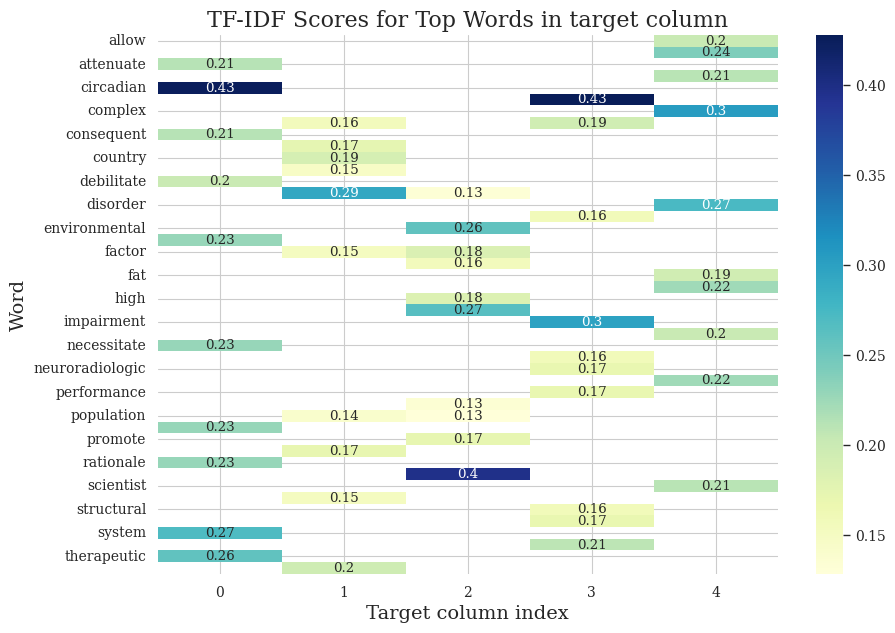

In [56]:
# Define the number of words and conversations to be considered
Nwords = 10
Ndocuments = 5

top_tfidf = tfidf_by_word.sort_values(by=['target_col_idx','tfidf'], ascending=[True,False]).groupby(['target_col_idx']).head(10)

# Only consider the first 5 conversations
top_tfidf = top_tfidf.iloc[:Nwords*Ndocuments]

# Function to get top N words by TF-IDF score
def get_top_n_words(df, n=10):
    return df.nlargest(n, 'tfidf')

# Get top 10 words for each conversation
top_words_per_conversation = top_tfidf.groupby('target_col_idx', group_keys=False).apply(get_top_n_words)

# Create a pivot table for heatmap
pivot_table = top_words_per_conversation.pivot(index='term', columns='target_col_idx', values='tfidf')

# Create the heatmap
fig, ax = plt.subplots(figsize = (10, 7))
sns.heatmap(pivot_table, ax = ax, annot=True, cmap='YlGnBu', cbar=True)
ax.set(xlabel='Target column index', ylabel='Word', title='TF-IDF Scores for Top Words in target column');

## Topic Modelling with Latent Dirichlet Allocation

First, we need to make a list of lists, where each inner list contains the words of a document

In [59]:
# Define a function to convert sentences to words
def sent_to_words(sentences):
    # Loop over each sentence in the list of sentences
    for sentence in sentences:
        # Use gensim's simple_preprocess to convert the sentence to a list of words.
        # The 'deacc=True' argument removes punctuations.
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

# Get the target column values from the 'data' DataFrame as a list
data_words = data[target_column].values.tolist()

# Apply the 'sent_to_words' function to preprocess the data
# The result is a list of lists, where each inner list contains words from a document
data_words = list(sent_to_words(data_words))


In [60]:
# words from the first document
print_list(data_words[0])

epidemic necessitate development novel therapeutic preventative strategy attenuate expansion debilitate
disease evidence link circadian system various aspect pathophysiology treatment aim
review outline rationale therapeutic target circadian system treatment prevention consequent
metabolic comorbidities


 Next, we convert the tokenized object into a corpus (set of texts in a structured manner) and dictionary containing value pairs.

In [61]:
# Create a Dictionary from the processed data_words
# The Dictionary object maps each unique word in the data to a unique integer ID
id2word = corpora.Dictionary(data_words)

# Create a Corpus using the original preprocessed data_words
# In this context, a "corpus" is simply a collection of documents (texts)
texts = data_words

# Create a Term Document Frequency corpus using the Dictionary
# 'doc2bow' counts the number of occurrences of each distinct word and converts the word to its integer ID
# The corpus is a list of vectors, one vector per document
corpus = [id2word.doc2bow(text) for text in texts]

# View a portion of the corpus to understand its structure
# The corpus is a list of lists, where each inner list contains tuples (word ID, word frequency) for a document
# The following line prints the first 30 word ID and frequency pairs for the first document in the corpus
print(corpus[:1][0][:30])


[(0, 1), (1, 1), (2, 1), (3, 2), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 2), (24, 1), (25, 2), (26, 2), (27, 1)]


#### Make topics

In [72]:
# Set the number of topics to be extracted by the LDA model
num_topics = 4

# Build the LDA model using gensim's LdaMulticore
# 'corpus' contains the bag-of-words representation of each document
# 'id2word' is a dictionary that maps word IDs to actual words
# 'num_topics' specifies the number of topics to be extracted
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics, random_state=42)

# Pretty-print the topics extracted by the LDA model
# Each topic is represented as a list of keywords and their associated weights

print(f"Each topic 0-{num_topics-1} is represented by a list of keywords and their associated importance:\n")
pprint(lda_model.print_topics())

# Apply the LDA model to the corpus to transform each document into a distribution of topics
# 'doc_lda' will contain the topic distribution for each document in the corpus
doc_lda = lda_model[corpus]

Each topic 0-3 is represented by a list of keywords and their associated importance:

[(0,
  '0.014*"patient" + 0.013*"tdm" + 0.013*"disease" + 0.012*"insulin" + '
  '0.011*"risk" + 0.007*"factor" + 0.007*"glucose" + 0.007*"treatment" + '
  '0.007*"study" + 0.006*"control"'),
 (1,
  '0.012*"risk" + 0.011*"tdm" + 0.010*"disease" + 0.008*"management" + '
  '0.007*"complication" + 0.007*"patient" + 0.007*"treatment" + '
  '0.006*"increase" + 0.006*"insulin" + 0.006*"factor"'),
 (2,
  '0.014*"patient" + 0.010*"disease" + 0.009*"treatment" + 0.007*"care" + '
  '0.007*"risk" + 0.007*"tdm" + 0.007*"increase" + 0.006*"associate" + '
  '0.006*"complication" + 0.006*"factor"'),
 (3,
  '0.015*"tdm" + 0.010*"disease" + 0.009*"risk" + 0.009*"study" + '
  '0.008*"patient" + 0.007*"increase" + 0.007*"factor" + 0.006*"control" + '
  '0.006*"treatment" + 0.006*"review"')]


### Visualize topics

This allows us to
* see if we need to remove common and/or uninformative words by adding them to the list of stopwords
* see if the number of topics is meaningful (overlapping topics indicates too few topics, whereas super specific and meaningless topics indicates too many)
* decrease the $\lambda$ parameter (upper right corner) to increase the importance of rare words and decrease the importance of common words (a common choice is $\lambda = 0.33$)



In [77]:

save = False
load = False
LDAvis_savepath = os.path.join('ldavis_prepared_'+str(num_topics))
LDAvis_loadpath = os.path.join('ldavis_prepared_'+str(num_topics))

# Enable the notebook mode for pyLDAvis
# This allows for interactive topic model visualization inline in a Jupyter Notebook
pyLDAvis.enable_notebook()
# Prepare LDA visualization using the LDA model, corpus, and dictionary
LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, corpus, id2word,)

if save:
    # Save the LDA visualization as an HTML file
    pyLDAvis.save_html(LDAvis_prepared, 'ldavis_prepared_'+ str(num_topics) +'.html')
    # Save the prepared LDA visualization data to a file using pickle
    with open(LDAvis_savepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)
if load:
    with open(LDAvis_loadpath, 'rb') as f:
        LDAvis_prepared = pickle.load(f)


# Display the prepared LDA visualization
# Note: This would display the interactive LDA visualization inline if run in a Jupyter Notebook
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.009921  0.012119       1        1  37.699158
1      0.017729 -0.013739       2        1  22.455144
3     -0.019564 -0.011007       3        1  19.968103
2      0.011756  0.012628       4        1  19.877596, topic_info=                 Term        Freq       Total Category  logprob  loglift
199              care   61.000000   61.000000  Default  30.0000  30.0000
194               tdm  176.000000  176.000000  Default  29.0000  29.0000
181        management   64.000000   64.000000  Default  28.0000  28.0000
163         associate   68.000000   68.000000  Default  27.0000  27.0000
57               gene   26.000000   26.000000  Default  26.0000  26.0000
212           patient  165.000000  165.000000  Default  25.0000  25.0000
401             study   93.000000   93.000000  Default  24.0000  24.0000
620             youth   22.000000   22.000000  Default  23.0000  23.0000
552              self   25.000000   25.000000  Default  22.0000  22.0000
26          treatment  103.000000  103.000000  Default  21.0000  21.0000
62           increase   96.000000   96.000000  Default  20.0000  20.0000
21             review   64.000000   64.000000  Default  19.0000  19.0000
78                new   37.000000   37.000000  Default  18.0000  18.0000
89               risk  148.000000  148.000000  Default  17.0000  17.0000
19         prevention   33.000000   33.000000  Default  16.0000  16.0000
323           outcome   30.000000   30.000000  Default  15.0000  15.0000
40            control   77.000000   77.000000  Default  14.0000  14.0000
396           provide   27.000000   27.000000  Default  13.0000  13.0000
201          disorder   25.000000   25.000000  Default  12.0000  12.0000
58             health   52.000000   52.000000  Default  11.0000  11.0000
2395    periodontitis   14.000000   14.000000  Default  10.0000  10.0000
117            family   26.000000   26.000000  Default   9.0000   9.0000
23             system   18.000000   18.000000  Default   8.0000   8.0000
114             early   36.000000   36.000000  Default   7.0000   7.0000
82         prevalence   38.000000   38.000000  Default   6.0000   6.0000
66               life   19.000000   19.000000  Default   5.0000   5.0000
22           strategy   24.000000   24.000000  Default   4.0000   4.0000
37       complication   90.000000   90.000000  Default   3.0000   3.0000
9            epidemic   18.000000   18.000000  Default   2.0000   2.0000
558             train   12.000000   12.000000  Default   1.0000   1.0000
2395    periodontitis   11.778868   14.830904   Topic1  -6.1622   0.7451
1175            sleep   10.797117   13.841722   Topic1  -6.2492   0.7271
2394      periodontal    4.020528    5.486438   Topic1  -7.2371   0.6647
2166             exam    1.960187    2.725002   Topic1  -7.9554   0.6461
2399             rage    3.269187    4.558541   Topic1  -7.4439   0.6431
2047         toxicity    1.971933    2.760020   Topic1  -7.9495   0.6393
1965        transport    2.604280    3.672115   Topic1  -7.6713   0.6319
1602            short    3.844313    5.448739   Topic1  -7.2819   0.6267
2629         glycogen    1.915512    2.754723   Topic1  -7.9785   0.6122
504           mention    1.897664    2.737341   Topic1  -7.9878   0.6092
1404     triglyceride    4.333783    6.304229   Topic1  -7.1620   0.6008
1798       australian    1.214908    1.808870   Topic1  -8.4338   0.5775
1797        australia    1.214840    1.808828   Topic1  -8.4339   0.5775
2052         lockdown    1.214444    1.808636   Topic1  -8.4342   0.5772
1828          guizhou    1.212975    1.808452   Topic1  -8.4354   0.5761
1646         cellular    3.066040    4.578692   Topic1  -7.5081   0.5745
2079             bill    1.207695    1.808186   Topic1  -8.4398   0.5719
2080      installment    1.206751    1.807950   Topic1  -8.4405   0.5713
1728          healthy    3.639501    5.461195   Topic1  

For (1), you can manually select each topic to view its top most frequent and/or “relevant” terms, using different values of the λ parameter. This can help when you’re trying to assign a human interpretable name or “meaning” to each topic.

For (2), exploring the Intertopic Distance Plot can help you learn about how topics relate to each other, including potential higher-level structure between groups of topics.

## Excercises:

### Exercise 1:

#### 1) Through exploration:
##### a) Look at the LDA visualization and determine a relevant number of topics.
##### b) Name the topics based on associated words.

### Exercise 2:
Look at the LDA visualization and add words to the stop list that you think are irrelevant and want to remove.
##### a) How did the LDA change?


#### 3) Now look at the LDA visualization through different lamda (λ) scopes.
##### a) How does it differ from λ 0.3 to a λ of 1?


### Exercise 3:

1. Choose your favorite combination of hyperparameters - train and evaluate your model. Can you do better than our previous model in terms of the accuracy on the train and validation data?
2. Use hyperparameter choosing to optimize one or more hyperparameters. Did the performance improve?


### Exercise 4:

Include the 3rd medicine group in the ATC 5 column and see if you can accurately classify all 3 classes!

Important things to account for:
- you must change the loss function from binary crossentropy to e.g. categorical crossentropy or another multi-classification loss function
- you must change the format of the target variable y to now have the shape [Npoints, Ncategories]. A row in y thus looks like either [0,0,1], [0,1,0] or [1,0,0], where 1 corresponds to the category that the given point belongs to.
- accuracy is not always the best metric for multi-classification problems. Have a look at other metrics like e.g. the f1 score

